# Test on the loss function scaling in deep and shallow circuits

In [3]:
import numpy as np
import pennylane as qml
import torch as th
from tqdm import tqdm
from matplotlib import pyplot as plt

### OLD

In [2]:
def generate_H(N):
    h = 9/N
    scale = 2**(N/2)

    Z = th.tensor([[1, 0], [0, -1]], dtype=th.complex128)

    ZZ = th.kron(Z, Z)

    H = th.zeros(2**N, 2**N, dtype=th.complex128)

    for i in range(N-1):
        H += th.kron( th.eye(2**i), th.kron(ZZ, th.eye(2**(N-i-2))) )

    return h*scale*H

def generate_dm(N,L,p):

    dev = qml.device("lightning.qubit", wires=N)
    @qml.qnode(dev)
    def circuit(params, bool_ghz):
        """Build a circuit using repeated custom layers."""
        L,N = params.shape

        # Prepare GHZ state
        if bool_ghz:
            qml.Hadamard(wires=0)
            for i in range(1, N):
                qml.CNOT(wires=[0, i])

        for l in range(L):
            for n in range(N):
                qml.RX(params[l,n], wires=n)
            for i in range(N-1):
                qml.CNOT(wires=[i,i+1])
        return qml.state()
        
    dm_state = th.zeros(2**N,2**N, dtype=th.complex128)

    n_run = 100

    params = np.random.uniform(0, np.pi, size=(L, N))

    for _ in range(n_run):
        # Sample whether to entangle or use CNOT at each layer
        entangle_flags = np.random.rand(L) < p  # Boolean array

        #print(entangle_flags)
        
        last_true_idx = np.where(entangle_flags)[0][-1] if np.any(entangle_flags) else 0        

        if last_true_idx<N:
            if last_true_idx == 0:
                bool_ghz = False
            else:
                bool_ghz = True
            #print("first",last_true_idx)
            l = last_true_idx   # number of effective layers 
            state = th.tensor(circuit(params[l:,:],bool_ghz))
        else:
            print("second",last_true_idx)
            state = th.zeros(2**N, dtype=th.complex128)
            state[0] = 1/np.sqrt(2)
            state[-1] = 1/np.sqrt(2)

        dm_state += th.outer(state.conj(), state)

    return dm_state / n_run

def calc_variance(N,L,p, n_sim=100):

    H = generate_H(N)

    res = []

    for _ in range(n_sim):
        
        state = generate_dm(N,L,p)

        # Run the circuit
        res.append(th.trace(state @ H).real)
    
    return np.mean(res),np.std(res)

### Circuit design

In [73]:
N = 4
L = 2

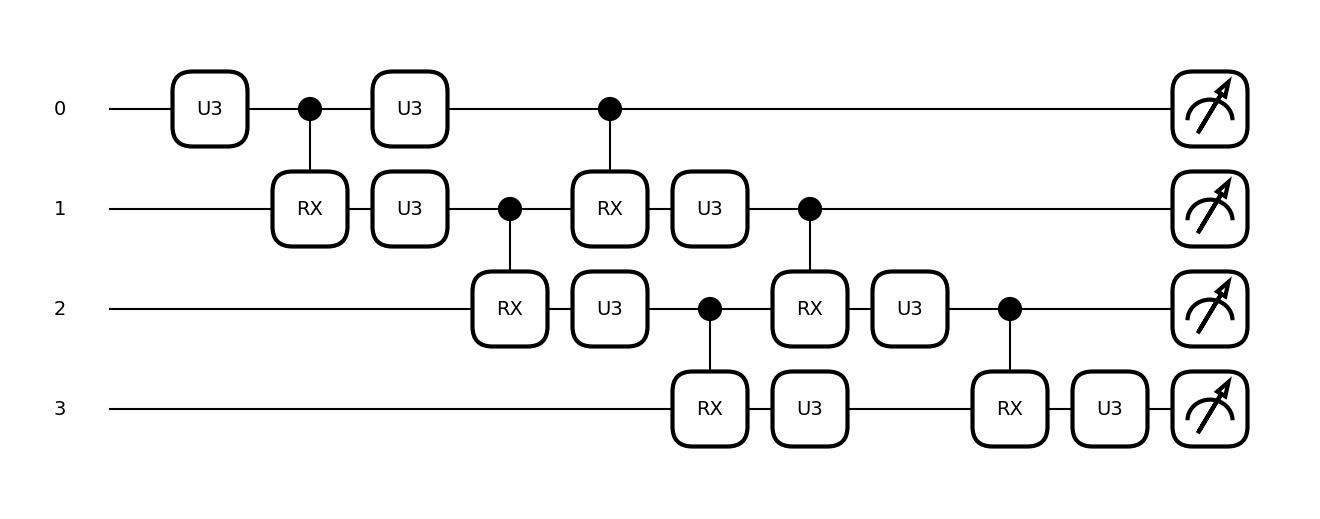

In [74]:
def generate_H(N):
    h = 9 / N
    scale = 2 ** (N / 2)

    coeffs = []
    observables = []

    for i in range(N - 1):
        op = qml.PauliZ(i) @ qml.PauliZ(i + 1)
        coeffs.append(1.0)  # You can scale later
        observables.append(op)

    H = qml.Hamiltonian([h * scale * c for c in coeffs], observables)
    return H

dev = qml.device("lightning.qubit", wires=N)
@qml.qnode(dev)
def circuit(params, phi, H):
    """Build a circuit using repeated custom layers."""
    L,N = params.shape[:2]

    for l in range(L):
        for n in range(N):
            qml.U3(params[l,n,0], params[l,n,1], params[l,n,2], wires=n)
            if n < N - 1:
                qml.CRX(phi[l,n],wires=[n,n+1])

    return qml.expval(H)

fig, ax = qml.draw_mpl(circuit,expansion_strategy="device",style="black_white")(np.ones((L, 4, 3)), np.ones((L, 4)), generate_H(4))

In [95]:
H = generate_H(N)
layers = np.arange(2,25,2)
n_sim = 10
n_sim_noise = 100
results = np.empty((len(layers), n_sim, n_sim_noise))
theta = np.pi/2

for l, layer in tqdm(enumerate(layers)):
    for i in range(n_sim):
        for j in range(n_sim_noise):
            params1 = np.arccos(1.0 - 2 * np.random.rand(layer, N))
            params2 = 2 * np.pi * np.random.rand(layer, N)
            params3 = 2 * np.pi * np.random.rand(layer, N)
            params = np.stack([params1, params2, params3], axis=2)
            phi = np.random.normal(theta, np.log(N)/((N-1) * layer), size=(layer, N-1))
            #phi = theta * np.zeros((layer, N))
            results[l,i,j] = circuit(params, phi, H)

12it [01:36,  8.04s/it]


In [82]:
results2=th.load("result1_4qbit.pt")

In [94]:
results.shape

(12, 10, 10)

In [96]:
var = np.std(np.mean(results,axis=2), axis=1)
var2 = []
for i in range(len(layers)):
    var2.append(th.std(results2[i]))

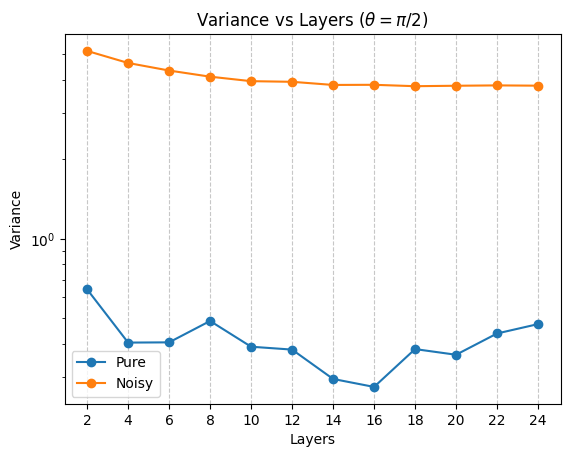

In [97]:
plt.semilogy(layers, var, marker='o', label='Pure')
plt.semilogy(layers, var2, marker='o', label='Noisy')
plt.xlabel('Layers')
plt.grid(axis='x', which='both', linestyle='--', alpha=0.7)
plt.xticks(layers)
plt.ylabel('Variance')
plt.title(r'Variance vs Layers ($\theta=\pi/2$)')
plt.legend()
plt.show()

## Test circuits

In [1]:
N = 4
L = 2

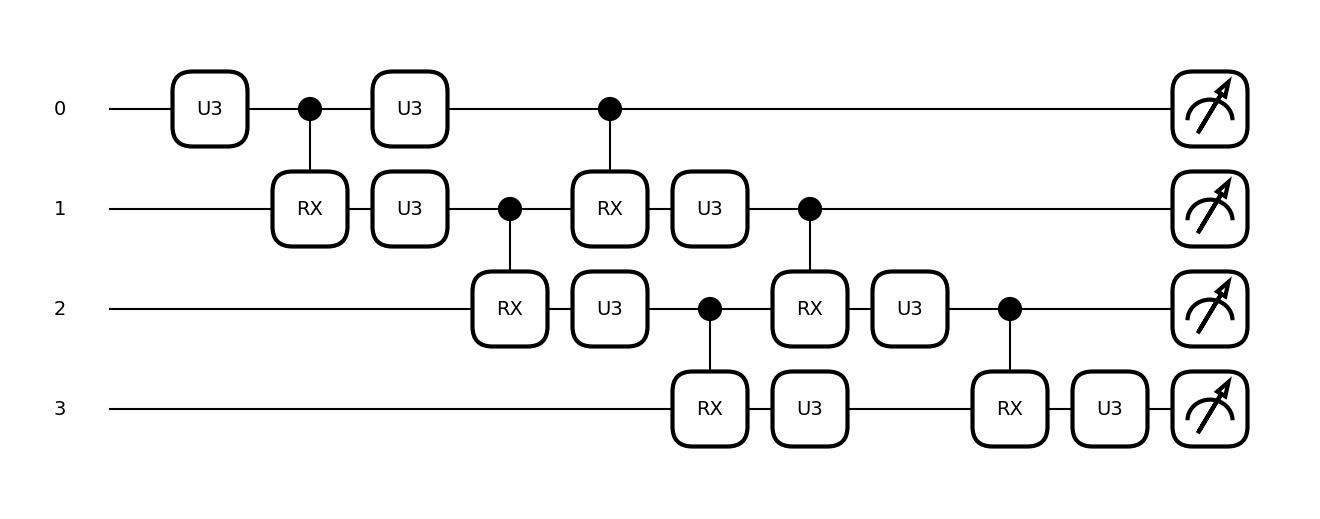

In [4]:
def generate_H(N):
    h = 9 / N
    scale = 2 ** (N / 2)

    coeffs = []
    observables = []

    for i in range(N - 1):
        op = qml.PauliZ(i) @ qml.PauliZ(i + 1)
        coeffs.append(1.0)  # You can scale later
        observables.append(op)

    H = qml.Hamiltonian([h * scale * c for c in coeffs], observables)
    return H

dev = qml.device("lightning.qubit", wires=N)
@qml.qnode(dev)
def circuit(params, phi, H):
    """Build a circuit using repeated custom layers."""
    L,N = params.shape[:2]

    for l in range(L):
        for n in range(N):
            qml.U3(params[l,n,0], params[l,n,1], params[l,n,2], wires=n)
            if n < N - 1:
                qml.CRX(phi[l,n],wires=[n,n+1])

    return qml.expval(H)

fig, ax = qml.draw_mpl(circuit,expansion_strategy="device",style="black_white")(np.ones((L, 4, 3)), np.ones((L, 4)), generate_H(4))

In [25]:
H = generate_H(N)
layers = np.arange(2,25,2)
n_sim = 1000
n_sim_noise = 10
results = np.empty((len(layers), n_sim, n_sim_noise))
theta = np.pi/2

for l, layer in enumerate(tqdm(layers)):
    for i in range(n_sim):
        for j in range(n_sim_noise):
            params1 = np.arccos(1.0 - 2 * np.random.rand(layer, N))
            params2 = 2 * np.pi * np.random.rand(layer, N)
            params3 = 2 * np.pi * np.random.rand(layer, N)
            params = np.stack([params1, params2, params3], axis=2)
            phi = np.random.normal(0, np.log(N)/((N-1) * layer)*theta, size=(layer, N-1))
            #phi = theta * np.zeros((layer, N))
            results[l,i,j] = circuit(params, phi, H)

100%|██████████| 12/12 [16:03<00:00, 80.30s/it] 


In [ ]:
results2=th.load("result1_4qbit.pt")
var2 = []
for i in range(len(layers)):
    var2.append(th.std(results2[i]))

In [31]:
var = np.std(results[:,:,2], axis=1)
var0 = np.std(np.mean(results,axis=2), axis=1)

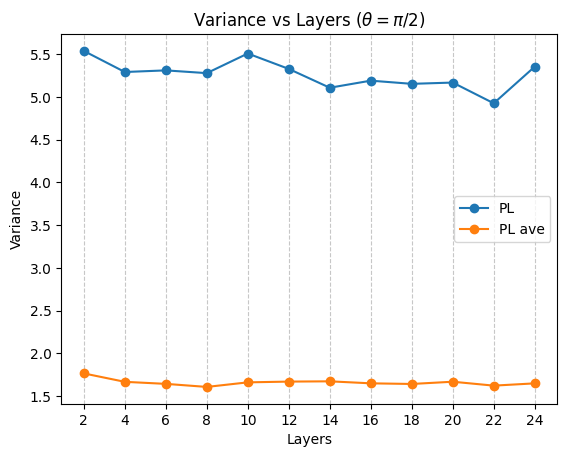

In [32]:
plt.plot(layers, var, marker='o', label='PL')
plt.plot(layers, var0, marker='o', label='PL ave')
#plt.semilogy(layers, var2, marker='o', label='Noisy')
plt.xlabel('Layers')
plt.grid(axis='x', which='both', linestyle='--', alpha=0.7)
plt.xticks(layers)
plt.ylabel('Variance')
plt.title(r'Variance vs Layers ($\theta=\pi/2$)')
plt.legend()
plt.show()